In [36]:
%load_ext autoreload
%autoreload 2
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
from os.path import join as oj
import seaborn as sns
from tqdm import tqdm
from copy import deepcopy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
results_dir = '/accounts/projects/vision/chandan/class-weight-uncertainty/results/pmlb'
os.makedirs(results_dir, exist_ok=True)
# out_dir = '/scratch/users/vision/chandan/pacmed/flips/logistic_stability'
out_dir = '/scratch/users/vision/chandan/pacmed/flips/mlp2_stability'
fnames = sorted([fname for fname in os.listdir(out_dir)])
results_list = [pd.Series(pkl.load(open(oj(out_dir, fname), "rb"))) for fname in tqdm(fnames)]
results = pd.concat(results_list, axis=1).T.infer_objects()

100%|██████████| 28/28 [00:00<00:00, 215.45it/s]


**note - cw is class-weight an pe is predictive-entropy**

In [38]:
# results.describe()

# compare different class weights

In [39]:
r = results

In [40]:
def plot_corr(corr):
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(10, 220, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.2, center=0,
                square=True, linewidths=.5, annot=True, 
                cbar_kws={"shrink": .5})

In [41]:
r = results
mean_corrs = []
dset_names = []
for d in np.unique(r.dset_name):
    r_d = r[r.dset_name == d].sort_values(by='class_weight')['cw_ranks_test'].values
    ranks = np.array([np.array(arr) for arr in r_d]) # num class_weights x n
    ranks_df = pd.DataFrame(ranks).transpose()
    corr = ranks_df.corr()
    mean_corr = (np.sum(corr.values[0]) - 1) / (corr.shape[0] - 1)
    mean_corrs.append(mean_corr)
    dset_names.append(d.replace("_", "\_"))
    
out_df = pd.DataFrame({'mean_corr': mean_corrs, 'dset_name': pd.Series(dset_names).str.lower()})
out_df = out_df.sort_values(by='dset_name') #, ascending=False)
# out_df = out_df.sort_values(by='mean_corr', ascending=False)

In [42]:
for i, r in out_df.iterrows():
    print(f'{r.dset_name}\t&\t{r.mean_corr: 0.2f} \\\\')

agaricus-lepiota	&	-0.02 \\
gametes\_epistasis\_2-way\_1000atts\_0.4h\_edm-1\_edm-1\_1	&	-0.06 \\
gametes\_epistasis\_2-way\_20atts\_0.1h\_edm-1\_1	&	 0.06 \\
gametes\_epistasis\_2-way\_20atts\_0.4h\_edm-1\_1	&	 0.02 \\
gametes\_epistasis\_3-way\_20atts\_0.2h\_edm-1\_1	&	 0.01 \\
gametes\_heterogeneity\_20atts\_1600\_het\_0.4\_0.2\_50\_edm-2\_001	&	 0.04 \\
gametes\_heterogeneity\_20atts\_1600\_het\_0.4\_0.2\_75\_edm-2\_001	&	 0.03 \\
hill\_valley\_with\_noise	&	 0.06 \\
hill\_valley\_without\_noise	&	 0.05 \\


(array([1., 0., 0., 1., 0., 1., 2., 1., 0., 3.]),
 array([-0.05972512, -0.04742227, -0.03511941, -0.02281655, -0.0105137 ,
         0.00178916,  0.01409202,  0.02639487,  0.03869773,  0.05100059,
         0.06330344]),
 <a list of 10 Patch objects>)

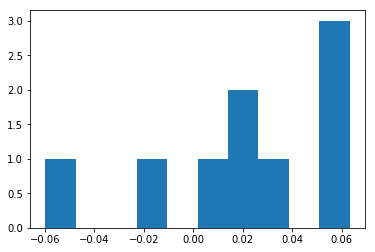

In [43]:
plt.hist(out_df.mean_corr)